# Getting data

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
import pandas as pd
df=pd.read_csv('gdrive/My Drive/crashes.csv')

<ipython-input-8-619539358847>:2: DtypeWarning: Columns (3,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('gdrive/My Drive/crashes.csv')


In [10]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from datetime import datetime


# Subsetting data
Dataset includes data over a long period of time. I will check to see if data has been consistently collected over the whole time period and select a period of time to use for this analysis.

If possible, it would be ideal to use only pre-COVID data to help model find predictable trends without the decline in travel from the lockdown affecting the model's accuracy.

In [11]:
df['accident_year'] = df['accident_year'].astype(int)

accident_year  month    
2005           April        268
               August       258
               December     252
               February     224
               January      245
                           ... 
2023           March        240
               May          218
               November     245
               October      293
               September    271
Length: 228, dtype: int64


<Axes: xlabel='accident_year,month'>

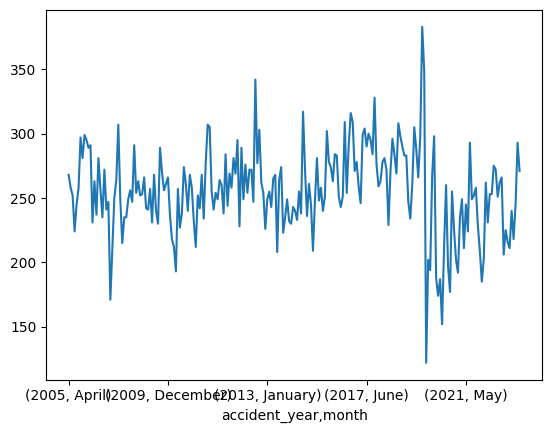

In [12]:
# there is an expected drop in accidents around early 2020
# most likely due to the pandemic
yearly_counts = df.groupby(by=['accident_year', 'month']).size()
print(yearly_counts)
yearly_counts.plot(kind='line')

In [13]:
selected_years = df[(df['accident_year'] < 2020) & (df['accident_year'] > 2013)].sort_values(by='collision_datetime')

# Selecting columns

In [14]:
selected_years.head()

,unique_id,cnn_intrsctn_fkey,cnn_sgmt_fkey,case_id_pkey,tb_latitude,tb_longitude,geocode_source,geocode_location,collision_datetime,collision_date,...,party2_move_pre_acc,point,data_as_of,data_updated_at,data_loaded_at,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods
1556,32694,25315000.0,NaN,140000140,37.795945,-122.421768,SFPD-CROSSROADS,CITY STREET,01/01/2014 01:02:00 AM,2014 January 01,...,Proceeding Straight,POINT (-122.421768167 37.795945403),01/01/2014 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,105.0,105.0,4.0,3.0,32.0
30178,42787,27519000.0,NaN,140000532,37.772569,-122.484194,SFPD-CROSSROADS,CITY STREET,01/01/2014 03:07:00 AM,2014 January 01,...,Proceeding Straight,POINT (-122.484194201 37.772569062),01/01/2014 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,8.0,8.0,8.0,4.0,29.0
18622,15931,30745000.0,8752202.0,140000463,37.777512,-122.416284,SFPD-CROSSROADS,CITY STREET,01/01/2014 03:12:00 AM,2014 January 01,...,NaN,POINT (-122.416284483 37.777512437),01/01/2014 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,21.0,21.0,5.0,10.0,34.0
4208,3204,20496000.0,10815000.0,140001944,37.733016,-122.390879,SFPD-CROSSROADS,CITY STREET,01/01/2014 03:59:00 PM,2014 January 01,...,Parked,POINT (-122.390879003 37.733015761),01/01/2014 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,86.0,86.0,2.0,9.0,1.0
20670,39694,23377000.0,1814000.0,140002049,37.741691,-122.493868,SFPD-CROSSROADS,CITY STREET,01/01/2014 04:00:00 PM,2014 January 01,...,Parked,POINT (-122.493867758 37.741690713),01/01/2014 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,40.0,40.0,10.0,7.0,35.0


In [15]:
selected_years.columns

Index(['unique_id', 'cnn_intrsctn_fkey', 'cnn_sgmt_fkey', 'case_id_pkey',
       'tb_latitude', 'tb_longitude', 'geocode_source', 'geocode_location',
       'collision_datetime', 'collision_date', 'collision_time',
       'accident_year', 'month', 'day_of_week', 'time_cat', 'juris',
       'officer_id', 'reporting_district', 'beat_number', 'primary_rd',
       'secondary_rd', 'distance', 'direction', 'weather_1', 'weather_2',
       'collision_severity', 'type_of_collision', 'mviw', 'ped_action',
       'road_surface', 'road_cond_1', 'road_cond_2', 'lighting',
       'control_device', 'intersection', 'vz_pcf_code', 'vz_pcf_group',
       'vz_pcf_description', 'vz_pcf_link', 'number_killed', 'number_injured',
       'street_view', 'dph_col_grp', 'dph_col_grp_description',
       'party_at_fault', 'party1_type', 'party1_dir_of_travel',
       'party1_move_pre_acc', 'party2_type', 'party2_dir_of_travel',
       'party2_move_pre_acc', 'point', 'data_as_of', 'data_updated_at',
       'data_

In [16]:
selected_years.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19575 entries, 1556 to 5475
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   unique_id                     19575 non-null  int64  
 1   cnn_intrsctn_fkey             19575 non-null  float64
 2   cnn_sgmt_fkey                 8003 non-null   float64
 3   case_id_pkey                  19575 non-null  object 
 4   tb_latitude                   19469 non-null  float64
 5   tb_longitude                  19469 non-null  float64
 6   geocode_source                19575 non-null  object 
 7   geocode_location              19575 non-null  object 
 8   collision_datetime            19575 non-null  object 
 9   collision_date                19575 non-null  object 
 10  collision_time                19540 non-null  object 
 11  accident_year                 19575 non-null  int64  
 12  month                         19575 non-null  object 
 13  day_

# map

In [17]:
! pip install folium

In [18]:
mean_lat = selected_years['tb_latitude'].mean()
mean_long = selected_years['tb_longitude'].mean()

In [19]:
selected_years['tb_latitude'].describe()


count    19469.000000
mean        37.766058
std          0.024488
min         37.707459
25%         37.749391
50%         37.772624
75%         37.783991
max         37.829991
Name: tb_latitude, dtype: float64

In [20]:
selected_years['tb_longitude'].describe()


count    19469.000000
mean      -122.427714
std          0.028412
min       -122.513615
25%       -122.441020
50%       -122.420705
75%       -122.407534
max       -122.363288
Name: tb_longitude, dtype: float64

All possible latitude and longitude values within the city limits should fit in this area. I'll encode the accidents by assigning them to a cell in a square matrix that covers this area.

In [21]:
import folium
m = folium.Map(location=(mean_lat, mean_long), zoom_start=12)
folium.Marker(
    location = [37.71, -122.53]
).add_to(m)
folium.Marker(
    location = [37.84, -122.34]
).add_to(m)
folium.Marker(
    location = [37.84, -122.53]
).add_to(m)
folium.Marker(
    location = [37.71, -122.34]
).add_to(m)
m

In [22]:
import numpy as np

# min and max values where all accidents should be within
max_lat = 37.84
min_lat = 37.70
max_long = -122.35
min_long = -122.52

# generate 31 equally spaced points within the latitude and longitude ranges (30x30 grid)
lat_values = np.linspace(min_lat, max_lat, 31)
long_values = np.linspace(min_long, max_long, 31)

# center map
mean_lat = np.mean(lat_values)
mean_long = np.mean(long_values)
m = folium.Map(location=(mean_lat, mean_long), zoom_start=12)

# horizontal grid lines
for lat in lat_values:
    polyline = [(lat, min_long), (lat, max_long)]
    folium.PolyLine(locations=polyline, color='blue').add_to(m)

# vertical grid lines
for long in long_values:
    polyline = [(min_lat, long), (max_lat, long)]
    folium.PolyLine(locations=polyline, color='blue').add_to(m)

m

In [23]:
grid_boundaries = []

# Iterate through latitude values
for i in range(len(lat_values) - 1):
    lat1, lat2 = lat_values[i], lat_values[i + 1]
    # Iterate through longitude values
    for j in range(len(long_values) - 1):
        long1, long2 = long_values[j], long_values[j + 1]
        # Define the boundaries of the grid area
        boundary = [(lat1, long1), (lat1, long2), (lat2, long2), (lat2, long1), (lat1, long1)]
        # Append the boundary to the list
        grid_boundaries.append(boundary)

# Display the list of boundaries
for idx, boundary in enumerate(grid_boundaries):
    print(f"Grid Area {idx + 1}: {boundary}")

Grid Area 1: [(37.7, -122.52), (37.7, -122.51433333333333), (37.70466666666667, -122.51433333333333), (37.70466666666667, -122.52), (37.7, -122.52)]
Grid Area 2: [(37.7, -122.51433333333333), (37.7, -122.50866666666666), (37.70466666666667, -122.50866666666666), (37.70466666666667, -122.51433333333333), (37.7, -122.51433333333333)]
Grid Area 3: [(37.7, -122.50866666666666), (37.7, -122.503), (37.70466666666667, -122.503), (37.70466666666667, -122.50866666666666), (37.7, -122.50866666666666)]
Grid Area 4: [(37.7, -122.503), (37.7, -122.49733333333333), (37.70466666666667, -122.49733333333333), (37.70466666666667, -122.503), (37.7, -122.503)]
Grid Area 5: [(37.7, -122.49733333333333), (37.7, -122.49166666666666), (37.70466666666667, -122.49166666666666), (37.70466666666667, -122.49733333333333), (37.7, -122.49733333333333)]
Grid Area 6: [(37.7, -122.49166666666666), (37.7, -122.48599999999999), (37.70466666666667, -122.48599999999999), (37.70466666666667, -122.49166666666666), (37.7, -12

In [24]:
selected_years.dropna(subset = ['tb_latitude', 'tb_longitude'], inplace=True)

In [25]:
# Create a dictionary to store the matrices for each date
date_matrices = {}

# Group the dataframe by 'collision_date'
grouped_dates = selected_years.groupby('collision_date')

# Iterate through each date group
for date, group in grouped_dates:
    # Create a 30x30 matrix initialized with zeros
    matrix = np.zeros((30, 30), dtype=int)

    # Iterate through each row in the group
    for index, row in group.iterrows():
        # Compute the indices for the matrix
        lat_index = int((row['tb_latitude'] - min_lat) / (max_lat - min_lat) * 30)
        long_index = int((row['tb_longitude'] - min_long) / (max_long - min_long) * 30)

        # Increment the corresponding cell in the matrix
        matrix[lat_index, long_index] += 1

    # Store the matrix in the dictionary with the date as the key
    date_matrices[date] = matrix

In [27]:
# Check if daily accident sums are equal
daily_count = grouped_dates.size().to_list()
matrices_sum = []
for key in date_matrices.keys():
  matrices_sum.append(sum(sum(date_matrices[key])))
daily_count == matrices_sum

True

# Make input suitable for LSTM

In [41]:
# Prepare input matrices
dates = list(date_matrices.keys())
matrices = [date_matrices[date] for date in dates]
input_matrices = np.array(matrices)

# Prepare target matrices
# Shift the matrices by one time step for sequence prediction
target_matrices = np.roll(input_matrices, -1, axis=0)

In [43]:
# Extract day of week and month
days_of_week = [date.weekday() for date in date_objects]  # 0: Monday, 1: Tuesday, ..., 6: Sunday
months = [date.month for date in date_objects]  # 1: January, 2: February, ..., 12: December

from sklearn.preprocessing import OneHotEncoder

# Create OneHotEncoder instance
encoder = OneHotEncoder(categories='auto', sparse_output=False)

# Reshape days_of_week and months to be a column vector
days_of_week_array = np.array(days_of_week).reshape(-1, 1)
months_array = np.array(months).reshape(-1, 1)

# Fit and transform the data
encoded_days_of_week = encoder.fit_transform(days_of_week_array)
encoded_months = encoder.fit_transform(months_array)

# Train validation test split

In [45]:
from sklearn.model_selection import train_test_split
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(input_matrices, target_matrices, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define model

In [51]:
from keras.models import Model
from keras.layers import LSTM, Dense, Input, concatenate, Reshape, Flatten

In [52]:
# Input shapes
input_shape_matrices = (30, 30)
input_shape_day_of_week = (7,)
input_shape_month = (12,)

# Define input layers
input_matrices_layer = Input(shape=input_shape_matrices)
input_day_of_week = Input(shape=input_shape_day_of_week)
input_month = Input(shape=input_shape_month)

# Concatenate the day of week and month inputs
concatenated_inputs = concatenate([input_day_of_week, input_month])

# Reshape concatenated input to include the timestep dimension
reshaped_inputs = Reshape((1, -1))(concatenated_inputs)

# Define LSTM layer for processing the concatenated input
lstm_out = LSTM(units=64)(reshaped_inputs)

# Flatten the matrix input
flattened_matrices = Flatten()(input_matrices_layer)

# Concatenate LSTM output with the flattened matrix input
concatenated_outputs = concatenate([lstm_out, flattened_matrices])

# Define output layer
output = Dense(units=30*30, activation='linear')(concatenated_outputs)  # Output is a matrix

# Reshape output to match the shape of the input matrix
output = Reshape((30, 30))(output)

# Define the model
model = Model(inputs=[input_matrices_layer, input_day_of_week, input_month], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 7)]                  0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 12)]                 0         []                            
                                                                                                  
 concatenate_2 (Concatenate  (None, 19)                   0         ['input_8[0][0]',             
 )                                                                   'input_9[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 1, 19)                0         ['concatenate_2[0][0]']   

In [53]:
# Fit model
history = model.fit(
    [X_train, encoded_days_of_week[:len(X_train)], encoded_months[:len(X_train)]],
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=([X_val, encoded_days_of_week[len(X_train):len(X_train)+len(X_val)], encoded_months[len(X_train):len(X_train)+len(X_val)]], y_val)
)

Epoch 1/50
48/48 [==============================] - 5s 39ms/step - loss: 0.0171 - mae: 0.0753 - val_loss: 0.0150 - val_mae: 0.0649
Epoch 2/50
48/48 [==============================] - 1s 20ms/step - loss: 0.0123 - mae: 0.0524 - val_loss: 0.0129 - val_mae: 0.0506
Epoch 3/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0104 - mae: 0.0405 - val_loss: 0.0121 - val_mae: 0.0430
Epoch 4/50
48/48 [==============================] - 1s 24ms/step - loss: 0.0095 - mae: 0.0344 - val_loss: 0.0118 - val_mae: 0.0387
Epoch 5/50
48/48 [==============================] - 1s 26ms/step - loss: 0.0090 - mae: 0.0310 - val_loss: 0.0117 - val_mae: 0.0364
Epoch 6/50
48/48 [==============================] - 1s 27ms/step - loss: 0.0087 - mae: 0.0291 - val_loss: 0.0116 - val_mae: 0.0351
Epoch 7/50
48/48 [==============================] - 1s 23ms/step - loss: 0.0085 - mae: 0.0280 - val_loss: 0.0117 - val_mae: 0.0342
Epoch 8/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0083 - m

In [56]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([X_test, encoded_days_of_week[len(X_train)+len(X_val):], encoded_months[len(X_train)+len(X_val):]], y_test)

print("Test Loss:", test_loss)
print("Test MAE:", test_mae)


11/11 [==============================] - 0s 8ms/step - loss: 0.0137 - mae: 0.0388
Test Loss: 0.013731425628066063
Test MAE: 0.03881779685616493
